In [61]:
import os
import pickle
os.getcwd()

'/Users/gimpuleumoe/Documents/TUM2020S/2020-pooreumoe-msc-thesis/code/CP_dec'

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
import pickle
# import some useful functions (they are available in utils.py)
# from utils import *

In [63]:
from tensorly.decomposition import candecomp_parafac

In [64]:
# Load Tensor
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f)

In [65]:
adj_list = []
country_cutline = 30
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensor_raw[4*i:4 + 4*i][:,0:country_cutline,0:2*country_cutline], axis=0)
    adj_list.append(ajm)
travel_data = np.array(adj_list)

In [66]:
# travel_data =travel_tensor_raw

In [67]:
travel_data.shape

(50, 30, 60)

In [68]:
# #Graph differencing

# temp = []
# temp.append(np.zeros((30,60)))
# for i in range(50-1):
#     dif = travel_data[i+1] - travel_data[i]
#     temp.append(dif)
# travel_data = np.array(temp)

In [69]:
# Create serial tensors by slicing the time interval.
W = 1 # window size
serial_tensors = []
for i in range(len(travel_data)-W+1):
    serial_tensors.append(travel_data[i:i+1])
serial_tensors = np.array(serial_tensors)

In [70]:
serial_tensors.shape

(50, 1, 30, 60)

In [71]:
rank = 30
# A = np.random.random((serial_tensors[0].shape[1], rank)) #node
# B = np.random.random((serial_tensors[0].shape[2], rank)) #feature
# C = np.random.random((serial_tensors[0].shape[0], rank)) #time
init_ABC = candecomp_parafac.initialize_factors(travel_data, rank=rank)
A = init_ABC[1]
B = init_ABC[2]
C = np.array([init_ABC[0][0]])

A_array = []
C_array = []
Ct_B =0
B_At =0
alpha = 0.05
beta = 0.05
T_interval = len(serial_tensors)

for t in range(T_interval):
    Xt = serial_tensors[t]
    
  # optimiza A
    Ct_B = khatri_rao([C, B])
    Xt_mode1_transpose = tl.unfold(Xt, mode=1).T
    X = np.concatenate((Xt_mode1_transpose, np.sqrt(alpha)*A.T), axis=0)
    I = np.identity(A.shape[1])
    F = np.concatenate((Ct_B, np.sqrt(alpha)*I), axis=0)
    A = np.linalg.lstsq(F,X, rcond=None)[0].T
    A_array.append(A)

    # optimize C
    B_At = khatri_rao([B, A])
    Xt_mode3_transpose = tl.unfold(Xt, mode=0).T
    X = np.concatenate((Xt_mode3_transpose, np.sqrt(beta)*C.T), axis=0)
    I = np.identity(C.shape[1])
    F = np.concatenate((B_At, np.sqrt(beta)*I), axis=0)
    C = np.linalg.lstsq(F,X, rcond=None)[0].T
    C_array.append(C)

    if t % int(T_interval * .1) == 0:
        res_a = np.square(Ct_B.dot(A.T) - Xt_mode1_transpose)
        res_c = np.square(B_At.dot(C.T) - Xt_mode3_transpose)
        print("interation:", t, "| Loss (A):", res_a.mean(), "| Loss (C):", res_c.mean())

interation: 0 | Loss (A): 1.3111843869546416 | Loss (C): 1.045768844108663
interation: 5 | Loss (A): 0.9028291197209187 | Loss (C): 1.7892868356198266
interation: 10 | Loss (A): 1.176489299175949 | Loss (C): 2.4761759053162726
interation: 15 | Loss (A): 2.0243441660574306 | Loss (C): 4.035852537588373
interation: 20 | Loss (A): 2.784008996677507 | Loss (C): 6.041609355506355
interation: 25 | Loss (A): 4.867930483747041 | Loss (C): 7.160860748593537
interation: 30 | Loss (A): 2.8687128596198774 | Loss (C): 7.6061062692245125
interation: 35 | Loss (A): 10.038189585102508 | Loss (C): 22.043911085721163
interation: 40 | Loss (A): 8.539742276787173 | Loss (C): 16.645783994926344
interation: 45 | Loss (A): 1.067363058698787 | Loss (C): 1.3383632289821827


In [72]:
np.array(C_array).shape

(50, 1, 30)

In [73]:
# optimize B
# X = np.concatenate(, axis=0)
X_concat = tl.unfold(serial_tensors[0], mode=2).T
for x in range(len(serial_tensors)):
    if x>0:
        XtT_unfold = tl.unfold(serial_tensors[x], mode=2).T
        X_concat = np.concatenate((X_concat, XtT_unfold))

F_concat = khatri_rao([C_array[0], A_array[0]])
for i in range(len(C_array)):
    if i >0:
        F_concat = np.concatenate((F_concat, khatri_rao([C_array[i], A_array[i]])))
        
B = np.linalg.lstsq(F_concat,X_concat, rcond=None)[0].T

In [74]:
# Error comparision 

res_b_array=[]
res_rand_b_array=[]
for i in range(len(serial_tensors)):
    Xt = serial_tensors[i]
    Xt_mode2_transpose = tl.unfold(Xt, mode=2).T
    res_b = np.square(khatri_rao([A,C]).dot(B.T) - Xt_mode2_transpose)
    res_b_array.append(res_b.mean())
    rB = np.random.random((serial_tensors[0].shape[2], rank))
    rand_res_b = np.square(khatri_rao([A,C]).dot(rB.T) - Xt_mode2_transpose)
    res_rand_b_array.append(rand_res_b.mean())
#     print(res_b.mean(), rand_res_b.mean())

res_a = np.square(khatri_rao([C, B]).dot(A.T) - Xt_mode1_transpose)

res_c = np.square(khatri_rao([B, A]).dot(C.T) - Xt_mode3_transpose)
print(np.mean(res_b_array[10:]), np.mean(res_rand_b_array[10:]))
print(res_a.mean(), np.mean(res_b_array[10:]), res_c.mean())

10.024801295571352 18.50067678793506
0.6438421839189004 10.024801295571352 0.8101319488078468


In [75]:
np.array(A_array).shape

(50, 30, 30)

In [76]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
# save_object(home_adj_list, '../pkl/[weekly]home_adj_from20180107_2.pkl')

In [77]:
# save_object(A_array, '../pkl/COVID_Aopt.pkl')
# save_object(C_array, '../pkl/COVID_Copt.pkl')
# save_object(B, '../pkl/COVID_Bopt.pkl')

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

In [79]:
Aopt_array = A_array
Copt_array = C_array
Bstar = B
np.array(Aopt_array).shape # time x nodes # rank (21 54 19)
print(Bstar.shape) # Fature x rank
np.array(Copt_array).shape # time x 1 x rank

(60, 30)


(50, 1, 30)

In [80]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')

In [81]:
week_slices = week_slices[0::4]

In [82]:
week_slices

DatetimeIndex(['2016-01-10', '2016-02-07', '2016-03-06', '2016-04-03',
               '2016-05-01', '2016-05-29', '2016-06-26', '2016-07-24',
               '2016-08-21', '2016-09-18', '2016-10-16', '2016-11-13',
               '2016-12-11', '2017-01-08', '2017-02-05', '2017-03-05',
               '2017-04-02', '2017-04-30', '2017-05-28', '2017-06-25',
               '2017-07-23', '2017-08-20', '2017-09-17', '2017-10-15',
               '2017-11-12', '2017-12-10', '2018-01-07', '2018-02-04',
               '2018-03-04', '2018-04-01', '2018-04-29', '2018-05-27',
               '2018-06-24', '2018-07-22', '2018-08-19', '2018-09-16',
               '2018-10-14', '2018-11-11', '2018-12-09', '2019-01-06',
               '2019-02-03', '2019-03-03', '2019-03-31', '2019-04-28',
               '2019-05-26', '2019-06-23', '2019-07-21', '2019-08-18',
               '2019-09-15', '2019-10-13', '2019-11-10'],
              dtype='datetime64[ns]', freq='4W-SUN')

In [83]:
xaxis = week_slices[1:]

In [84]:
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [85]:
with open('../pkl/Twitter_label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f) 

In [86]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT'}

In [87]:
np.array(Aopt_array)[:,1,:].shape

(50, 30)

In [88]:
LOF_by_countries = []
for i in range(Aopt_array[0].shape[0]):
#     X = np.array(np.exp(Aopt_array))[:,i,:]
    X = np.array(Aopt_array)[:,i,:]
    clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
    clf.fit(X)
    neg_scores = clf.negative_outlier_factor_
#     lof_scores = (np.max(neg_scores) - neg_scores)/(np.max(neg_scores) - np.min(neg_scores))
    lof_scores = neg_scores * -1
    LOF_by_countries.append(lof_scores)
    

In [89]:
# # travel_data.shape
# tensors = travel_data[:,:,:54]

# cnt_num = 12
# intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
# print(intraffic)

# plt.figure(figsize=(12,5))
# plt.scatter(xaxis, intraffic)
# plt.axvline(x=xaxis[-15], linestyle='-', color='red', label="Massive spread")
# # plt.title(str(label_dict[cnt_num])+ " intraffic")

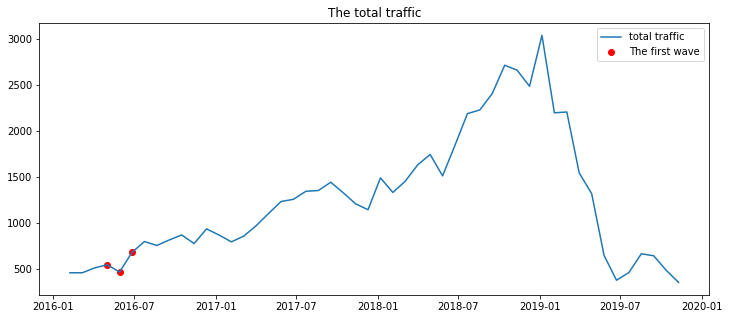

In [90]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape
xaxis = week_slices[1:]

traffic = np.sum(np.sum(tensors, 1),1) #in-traffic
plt.figure(figsize=(12,5))
plt.plot(xaxis, traffic, label= 'total traffic')
plt.scatter(xaxis[3:6], traffic[3:6], color='red', label = 'The first wave')
plt.title("The total traffic")
plt.legend()

In [91]:
from datetime import datetime  
from datetime import timedelta  

[21. 13.  5. 11. 10. 15. 10. 20. 21. 15. 13. 11. 12. 24. 18. 21. 18. 30.
 10. 22. 16. 22. 34. 43. 29. 38. 40. 34. 29. 26. 27. 30. 16. 24. 48. 45.
 41. 52. 38. 31. 32. 20. 13. 30.  5.  5. 29. 23. 23.  9.]


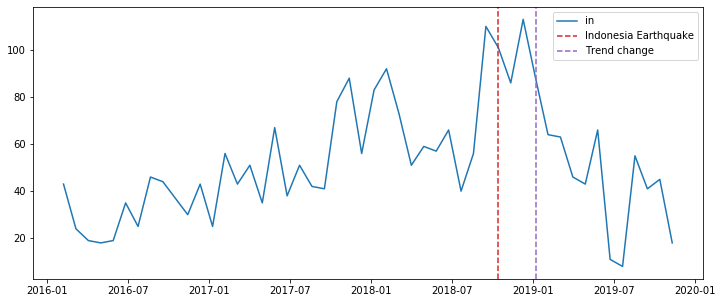

In [92]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 12
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
outtraffic = np.sum(tensors[:,cnt_num,:], 1) #outtraffic
print(intraffic)

plt.figure(figsize=(12,5))
plt.plot(xaxis, intraffic+outtraffic, label= 'in')
# plt.plot(xaxis, outtraffic+0.1, label='out', alpha=0.8)
plt.axvline(xaxis[-15], color='tab:red', label="Indonesia Earthquake", linestyle='--')
plt.axvline(xaxis[-12], color='tab:purple', label="Trend change", linestyle='--')
# plt.fill_between([xaxis[-19] + timedelta(days=1.5),xaxis[-17]], 0, 23, color='magenta', alpha=0.15, label = 'Surge in carriers mobility: 23.Feb ~ 29.Feb')
# plt.title(str(label_dict[cnt_num])+ " traffic")
plt.legend()

In [120]:
xaxis[-15]
xaxis[-17]

Timestamp('2018-08-19 00:00:00', freq='4W-SUN')

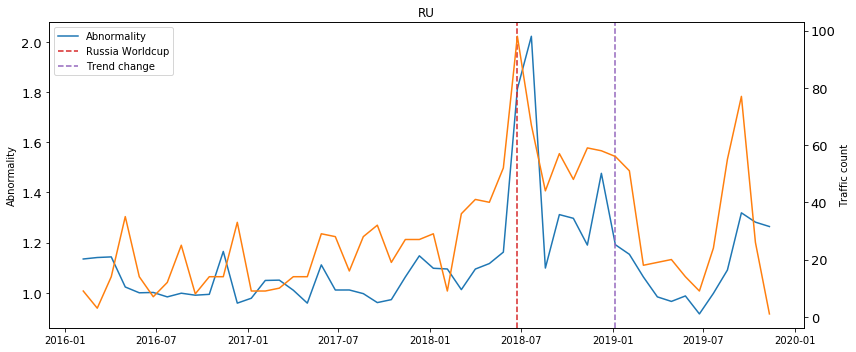

In [117]:
# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
fig, ax1 = plt.subplots(figsize=(12,5))

cnt_num = 24

color = 'tab:red'
# ax1.set_xlabel('Date')
ax1.set_ylabel('Abnormality')
ax1.plot(xaxis,LOF_by_countries[cnt_num], label= "Abnormality")
ax1.axvline(xaxis[-19], color='tab:red', label="Russia Worldcup", linestyle='--')
ax1.axvline(xaxis[-12], color='tab:purple', label="Trend change", linestyle='--')
# ax1.tick_params(fontsize=13)
ax1.tick_params(axis='y', labelsize=13)
plt.legend(loc=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Traffic count')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelsize=13)

intraffic = np.sum(tensors[:,:,cnt_num], axis=1)
outtraffic = np.sum(tensors[:,cnt_num,:], axis=1)
ax2.plot(xaxis, intraffic+outtraffic, label= 'total traffic', color='#ff7f0e')
# plt.legend(loc=1)
plt.title(label_dict[cnt_num])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [103]:
# plt.figure(figsize=(12,5))
# cnt_num = 24
# plt.plot(xaxis,LOF_by_countries[cnt_num])
# plt.axvline(xaxis[-19], color='tab:red', label="Russia Worldcup", linestyle='--')
# plt.axvline(xaxis[-12], color='tab:purple', label="Trend change", linestyle='--')
# # plt.legend()
# plt.yticks(fontsize=13)
# plt.ylabel('LOF score')
# plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[(cnt_num)]))
# plt.show()
# # plt.title('LOF score of ' + countries[18])

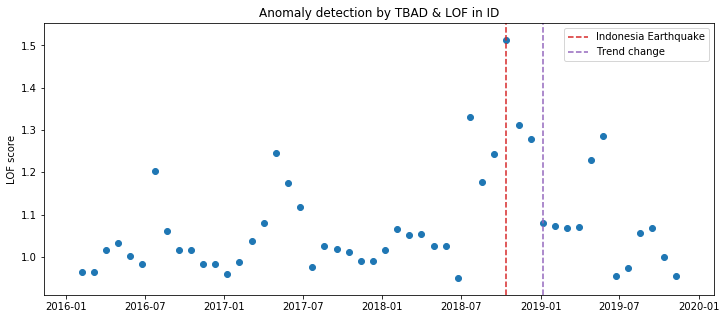

In [35]:
plt.figure(figsize=(12,5))
cnt_num = 12
plt.scatter(xaxis,LOF_by_countries[cnt_num])
plt.axvline(xaxis[-15], color='tab:red', label="Indonesia Earthquake", linestyle='--')
plt.axvline(xaxis[-12], color='tab:purple', label="Trend change", linestyle='--')
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[cnt_num]))
plt.show()
# plt.title('LOF score of ' + countries[18])

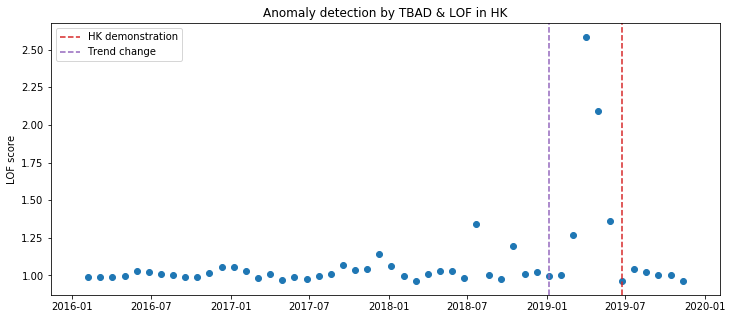

In [36]:
plt.figure(figsize=(12,5))
cnt_num = 28
plt.scatter(xaxis,LOF_by_countries[cnt_num])
plt.axvline(xaxis[-6], color='tab:red', label="HK demonstration", linestyle='--')
plt.axvline(xaxis[-12], color='tab:purple', label="Trend change", linestyle='--')
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[cnt_num]))
plt.show()
# plt.title('LOF score of ' + countries[18])

In [37]:
cutline = 1.5
cnt=0
for i in range(30):
    lof1 = LOF_by_countries[i][-12]
    lof2 = LOF_by_countries[i][-11]
    if((lof1>=cutline) | (lof2>=cutline)):
        cnt+=1
#         print(i)
print(cnt)

11


In [38]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 3
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
print(intraffic)

# plt.figure(figsize=(12,5))
# plt.scatter(xaxis, intraffic)
# plt.title(str(label_dict[cnt_num])+ " intraffic")

[  0.   5.  15.   9. -33.  36.  12.  -4. -11.  15. -20.  10.   6. -19.
   2.  12.  23.  11.   6.  -1.   7.  11. -19. -28.  14. -20.   5.  15.
   1.  34.  -8.   4.  76. -31.  12. -23. -16.  -7.  10. -37.  24. -37.
  -8.  -6. -30.   9.  14. -17. -21.  -2.]


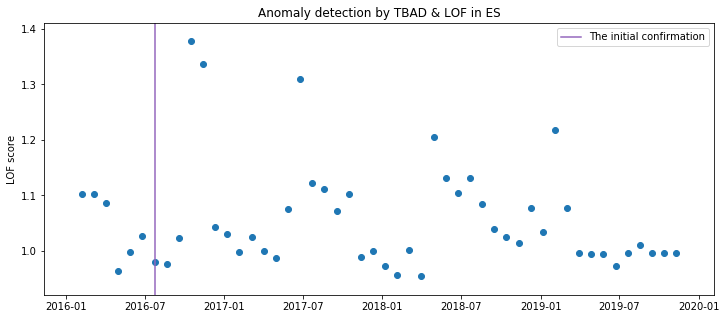

In [39]:
plt.figure(figsize=(12,5))
plt.scatter(xaxis,LOF_by_countries[3])
plt.axvline(xaxis[6], color='tab:purple', label="The initial confirmation")
plt.legend()
plt.ylabel('LOF score')
plt.title('Anomaly detection by TBAD & LOF in ' + label_dict[3])
plt.show()
# plt.title('LOF score of ' + countries[18])

In [40]:
xaxis[-6]

Timestamp('2019-06-23 00:00:00', freq='4W-SUN')

In [41]:
# plt.figure(figsize=(12,5))
# plt.scatter(xaxis,LOF_by_countries[47])
# plt.axvline(xaxis[-4], color ='tab:purple', label="The initial confirmation")
# plt.legend()
# plt.ylabel('LOF score')
# plt.title('Anomaly detection by TBAD & LOF in ' + str(label_dict[47]))
# plt.show()


In [42]:
Bstar.T.shape

(30, 60)

In [43]:
# ABt = []
# for Ai in Aopt_array:
#     ABt.append(Ai.dot(Bstar.T))
# ABt = np.array(ABt)

In [44]:
travel_data.shape

(50, 30, 60)

In [45]:
# regularized_adj = np.mean(Bstar.T, axis=0)
regularized_adj = Bstar.T
raw_adj = np.mean(travel_data[-25:-12,:,:30], axis=0)

In [46]:
# adjmat = regularized_adj

# df = pd.DataFrame([[-1,-1,-1]])
# for i in range(adjmat.shape[0]):
#     for j in range(adjmat.shape[0]):
#         if(i==j):
#             continue
#         if(adjmat[i,j]==0):
#             continue
#         else:
#             a_row = pd.Series([label_dict[i], label_dict[j], adjmat[i,j]])
#             row_df = pd.DataFrame([a_row])
#             df = pd.concat([df, row_df])
# #         df = pd.DataFrame(pd.Series(i,j,adjmat[i,j]), index=range(1),columns=['from','to','weight'])
# df = df.iloc[1:,:]
# df.columns = ['Source','Target','Weight']

In [47]:
# df=df.sort_values(by=['Weight'])
# df.reset_index().to_csv("../gephi/regularized_adj.csv")

In [48]:
# df.Weight = normalize(df.Weight)
# df.Weight = 10*(df.Weight - np.min(df.Weight))/(np.max(df.Weight)- np.min(df.Weight))
# df.to_csv("../gephi/regularized_adj.csv", index=False)

In [49]:
# plt.hist(df.Weight, bins=100)
# plt.show()

In [50]:
incoming = np.sum(regularized_adj[:,:30], axis=0)
outgoing = np.sum(regularized_adj[:,30:], axis=0)
raw_incoming = np.sum(raw_adj, axis=0)
raw_outgoing = np.sum(raw_adj, axis=1)

In [51]:
regularized_adj.shape

(30, 60)

In [52]:
def normalize(data):
#     a = data - np.min(data)
#     return a/(np.max(data)-np.min(data))
    return (data-np.mean(data))/np.std(data)
#     return data

In [53]:
net_traffic = normalize(incoming - outgoing)
net_traffic_raw = normalize(raw_incoming - raw_outgoing)

In [54]:
cnt=24
print(net_traffic[cnt], net_traffic_raw[cnt])

0.21843613222493652 0.45547001977806933


In [55]:
# incom_df = pd.DataFrame([label_dict[0],incoming[0]]).T
# outgo_df = pd.DataFrame([label_dict[0],outgoing[0]]).T
net_traffic_df = pd.DataFrame([label_dict[0],net_traffic[0]]).T
raw_net_traffic_df = pd.DataFrame([label_dict[0],net_traffic_raw[0]]).T
for node in range(1,30):
    d1 = [label_dict[node],net_traffic[node]]
    d2 = [label_dict[node],net_traffic_raw[node]]
    net_traffic_df = net_traffic_df.append(pd.Series(d1, index=net_traffic_df.columns),ignore_index=True)
    raw_net_traffic_df = raw_net_traffic_df.append(pd.Series(d2, index=raw_net_traffic_df.columns),ignore_index=True)
#     incom_df= incom_df.append(pd.Series([label_dict[node],incoming[node]], index=incom_df.columns),ignore_index=True)
#     outgo_df= outgo_df.append(pd.Series([label_dict[node],outgoing[node]], index=outgo_df.columns),ignore_index=True)

In [56]:
import folium
from  geopy.geocoders import Nominatim

In [57]:
ctr_code = pd.read_csv('country.csv')[['Alpha-2 code', 'Alpha-3 code']]

In [58]:
net_traffic_df.columns = ['Alpha-2 code', 'traffic']
raw_net_traffic_df.columns = ['Alpha-2 code', 'traffic']

In [59]:
# Set the map up
df = raw_net_traffic_df
result = pd.merge(df, ctr_code, how='left', on=['Alpha-2 code'])
map_hooray = folium.Map(location=[53.5074, -30.1278],
#                             tiles = "cartodbpositron",
                        tiles = "Stamen Terrain",
                        zoom_start = 2)
map_hooray.choropleth(geo_data='world-countries.json', 
                      data=result,
         columns=['Alpha-3 code', 'traffic'], 
         key_on='feature.id',
#          threshold_scale= np.arange(0, 110, 20).tolist(),
#         legend_name='Product Share(%)',
         fill_color='YlOrRd',
        nan_fill_color='white',
                      nan_fill_opacity=1,
                      fill_opacity=1, 
                      line_opacity=1)
map_hooray

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [60]:
# Set the map up
df = net_traffic_df
result = pd.merge(df, ctr_code, how='left', on=['Alpha-2 code'])
map_hooray = folium.Map(location=[53.5074, -30.1278],
#                             tiles = "cartodbpositron",
                        tiles = "Stamen Terrain",
                        zoom_start = 2)
map_hooray.choropleth(geo_data='world-countries.json', 
                      data=result,
         columns=['Alpha-3 code', 'traffic'], 
         key_on='feature.id',
#          threshold_scale= np.arange(0, 110, 20).tolist(),
#         legend_name='Product Share(%)',
         fill_color='YlOrRd',
        nan_fill_color='white',
                      nan_fill_opacity=1,
                      fill_opacity=1, 
                      line_opacity=1)
map_hooray